# Fun With Swaths

Mock a polar and a tropical orbiters observation swaths. Construct STARE spatial covers for each mock granule based on a STARE partitioning into _pods_, then determine which pods contain data from both data sets.

[Michael Rilee](mailto:mike@rilee.net) RSTLLC - 2021-10-09-2357-EDT

In [1]:
import pystare
import pystareplotlib
import pystareplotlib.pystareplotlib as psplot
from pystareplotlib.pystareplotlib import *

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm
import matplotlib.ticker as mticker

import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.geodesic import Geodesic

import numpy
import math
from math import sqrt,sin,cos

import pyproj
import scipy.linalg
from scipy.linalg import expm, norm

import geopandas
import starepandas

In [2]:
# Define Global Constants and State Variables
# -------------------------------------------

# Set up the projection and transformation
# PROJ = ccrs.PlateCarree()
# PROJ = ccrs.Robinson()
PROJ = ccrs.Mollweide()
TRANSF = ccrs.Geodetic()
USR_SET_GLOBAL = True

# Plot options
#matplotlib notebook
%matplotlib inline

usr_plot_options = {'projection': PROJ, 'transform': TRANSF}
DEFAULT_DPI = mpl.rcParamsDefault['figure.dpi']

#mpl.rcParams['figure.dpi'] = 1.5 * DEFAULT_DPI
#mpl.rcParams['legend.fontsize'] = 6

mpl.rcParams['figure.dpi'] = 2 * DEFAULT_DPI
mpl.rcParams['legend.fontsize'] = 6
mpl.rcParams['figure.figsize'] = [3, 3]

print('Current DPI: ',mpl.rcParamsDefault['figure.dpi'])

Current DPI:  100.0


In [3]:
nearside_plot_options = {
    'projection':
    ccrs.NearsidePerspective(central_longitude=0.0
                             ,central_latitude=45.0
                             ,satellite_height=35785831
                             ,false_easting=0
                             ,false_northing=0
                             ,globe=None)
    ,'transform': ccrs.Geodetic()
}
    

In [4]:
nearside_plot_options['projection'].threshold

219053.44391861386

In [5]:
pystare.__version__

'0.8.3+14.g133b15b'

In [6]:
sivs = make_stare_htm_info_from_sivs(make_all_stare_htm_at_level(level=4).htm.data)

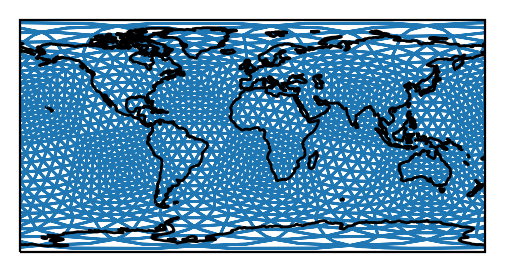

In [7]:
figax,sivs_cache,sivs_triang = hello_plot(
    spatial_index_values=sivs
    ,set_coastlines=True
#    ,plot_options=nearside_plot_options
    ,set_global=False
    ,show_fig=False)

plt.show() # May have to Cell->Current Outputs->Toggle Scrolling to see full figure.
del figax

In [8]:
crs_geocentric = ccrs.Geocentric()
crs_geodetic   = ccrs.Geodetic()

In [9]:
x=numpy.array([6378137,0,0],dtype=numpy.double)
y=numpy.array([0,6378137,0],dtype=numpy.double)
z=numpy.array([0,0,6.35675231e+06],dtype=numpy.double)
# z = None
crs_geodetic.transform_points(crs_geocentric,x,y,z)

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 9.00000000e+01,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  9.00000000e+01, -4.24517971e-03]])

In [10]:

xyz_to_lonlatalt= pyproj.Transformer.from_crs(
    {"proj":'geocent', "ellps":'WGS84', "datum":'WGS84'},
    {"proj":'latlong', "ellps":'WGS84', "datum":'WGS84'},
    )

lonlatalt_to_xyz = pyproj.Transformer.from_crs(
    {"proj":'latlong', "ellps":'WGS84', "datum":'WGS84'},
    {"proj":'geocent', "ellps":'WGS84', "datum":'WGS84'},
    )


In [11]:
x = -652954.1006
y = 4774619.7919
z = -2217647.7937
lon1, lat1, alt1 = xyz_to_lonlatalt.transform(x,y,z,radians=False)
print (lat1, lon1, alt1 )

lon1=0
lat1=0
alt1=0
x,y,z = lonlatalt_to_xyz.transform(lon1,lat1,alt1,radians=False)
print(x,y,z)

-24.887220848803032 97.78719043261641 -1069542.1692923503
6378137.0 0.0 0.0


In [12]:
xyz_to_lonlatalt.transform(1,0,0,radians=False)

(0.0, 90.0, -6356752.314245179)

In [13]:
lonlatalt_to_xyz.transform(0.0, 90.0, 0)

(3.9186209248144716e-10, 0.0, 6356752.314245179)

In [14]:
def to_xyz(lla):
    return lonlatalt_to_xyz.transform(lla[0],lla[1],lla[2],radians=False)
def to_lla(xyz):
    return xyz_to_lonlatalt.transform(xyz[0],xyz[1],xyz[2],radians=False)

In [15]:
# def norm(x):
#     return x/numpy.sqrt((x*x).sum())

def tri(center_lon,center_lat,delta_lon,delta_lat):
    x = numpy.array(lonlatalt_to_xyz.transform(center_lon,center_lat,0),dtype=numpy.double)
    p = numpy.array(lonlatalt_to_xyz.transform(center_lon+delta_lon,center_lat+delta_lat,0),dtype=numpy.double)
    n = numpy.cross(x,p); n = n/norm(n)
    return x,p,n

def rot(a,n,theta):
    M = expm(numpy.cross(numpy.eye(3),n*(theta*numpy.pi/180.0)))
    return numpy.dot(M,a)

def rotM(a,M):
    return numpy.dot(M,a)

def make_rot_matrix(n,theta):
    return expm(numpy.cross(numpy.eye(3),n*(theta*numpy.pi/180.0)))

def patch(x,n,along,across):
    xp = rot(x,n,along/2.0)
    xm = rot(x,n,-along/2.0)
    
    np  = numpy.cross(n,xp); np = np/norm(np)
    xpp = rot(xp,np,across/2.0)
    xpm = rot(xp,np,-across/2.0)
    
    nm  = numpy.cross(n,xm); nm = nm/norm(nm)
    xmp = rot(xm,nm,across/2.0)
    xmm = rot(xm,nm,-across/2.0)
    
    return [xmp,xpp,xpm,xmm]

def make_periodic(a):
    return a+a[0:1]

def patch_geodetic(p):
    return zip(*map(to_lla,p))

def patch_periodic(p):
    return map(make_periodic,patch_geodetic(p))

def make_swath(center_lon=0,center_lat=0,along=10,across=10,delta_deg=10,delta_lon=0.0,delta_lat=1.0
               ,cover_res=4
                ):
    "Return centers, g-rings (aka pp patches), and covers. Maybe promote this to a class..."
    t__ = tri(center_lon,center_lat,delta_lon,delta_lat)
    n  = t__[2]
    c0 = t__[0]
    centers      = [ rot(c0,n,i) for i in range(0,361,delta_deg) ]
    centers_llas = [ to_lla(c) for c in centers ]
    centers_lons,centers_lats,alts = zip(*centers_llas)
    patches      = [ patch(c,n,delta_deg,delta_deg) for c in centers ]
    pp_lons = []
    pp_lats = []
    pp_covers = []
    for p in patches:
        pp = list(patch_periodic(p))
        pp_lons.append(pp[0]); pp_lats.append(pp[1])
        pp_covers.append(pystare.expand_intervals(pystare.cover_from_hull(pp[1],pp[0],cover_res),cover_res))
        
    return centers_lons,centers_lats,pp_lons,pp_lats,pp_covers

In [16]:
centers_lons,centers_lats,pp_lons,pp_lats,pp_covers = make_swath(center_lat=60,delta_lon=1,delta_lat=2.0,delta_deg=20)
centers_lons1,centers_lats1,pp_lons1,pp_lats1,pp_covers1 = make_swath(center_lat=25,delta_lon=0.9,delta_lat=0.1,delta_deg=20)

In [17]:
pystare.from_latlon([60],[0],4)[0] >> 59

6

In [18]:
hex(7 << 59)

'0x3800000000000000'

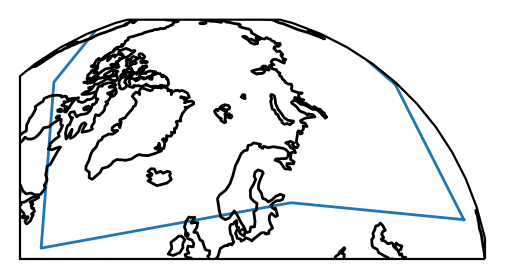

In [19]:
figax,sivs_cache,sivs_triang = hello_plot(
    spatial_index_values=[6<<59]
    ,set_coastlines=True
    ,plot_options=nearside_plot_options
    ,set_global=False
    ,show_fig=False)

plt.show() # May have to Cell->Current Outputs->Toggle Scrolling to see full figure.
del figax

In [20]:
def uniq_sivs(covers):
    "Return a dictionary of spatial index value -> list of covers from a list of covers."
    sivs = {}
    for c in covers:
        for s in c:
            try:
                sivs[s].append(c)
            except KeyError:
                sivs[s]=[c]
    return sivs

def join_sivs(sivs0,sivs1):
    """ Returns list with sivs in both dictionaries. Assumes all are the same resolution. 
    To relax this requirement, will need to add a cmp_spatial-like routine."""
    sivs01=[]
    for s in sivs0:
        if s in sivs1:
            sivs01.append(s)
    return sivs01

In [21]:
pp_sivs0  = uniq_sivs(pp_covers[15:18])
pp_sivs1  = uniq_sivs(pp_covers1[15:19])
pp_sivs01 = join_sivs(pp_sivs0,pp_sivs1)

In [22]:
sivs0 = make_stare_htm_info_from_sivs(make_all_stare_htm_at_level(level=0).htm.data)
sivs = make_stare_htm_info_from_sivs(make_all_stare_htm_at_level(level=4).htm.data)

In [23]:
# threshold_save = nearside_plot_options['projection'].threshold
# threshold_save # 219053.44391861386

In [24]:
nearside_plot_options['projection']._threshold = 10000.0

In [25]:
plot_options = nearside_plot_options
# plot_options = None

In [26]:
cd_cmap=plt.cm.get_cmap('rainbow')

In [27]:
pp_lons[0]

(11.04873351142328,
 28.854653826037545,
 -22.804345179284134,
 -19.220513325931936,
 11.04873351142328)

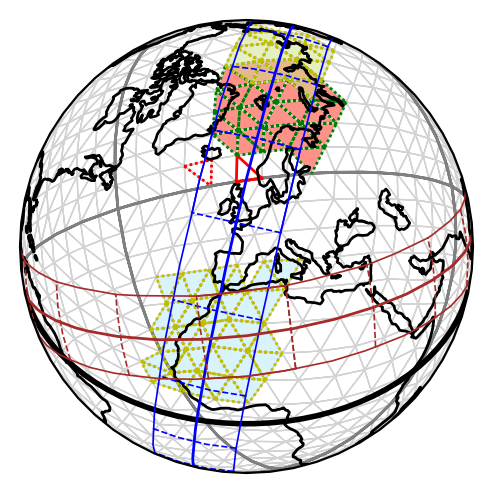

In [28]:
figax,sivs_cache,sivs_triang = hello_plot(
    spatial_index_values=sivs
    ,set_coastlines=True
    ,plot_options=plot_options
    ,set_global=True
    ,show_fig=False
    ,lw=0.5
    ,color='lightgrey')

if True:
    figax,sivs_cache,sivs_triang = hello_plot(
        figax=figax
        ,spatial_index_values=sivs0
        ,set_coastlines=True
        ,plot_options=plot_options
        ,set_global=True
        ,show_fig=False
        ,color='grey')

# i=0
# di=1024
# sivs.htm[i:i+di]
if True:
    figax,sivs_cache,sivs_triang = hello_plot(
        figax=figax
        ,spatial_index_values=pystare.from_latlon([60],[0],4)
        ,set_coastlines=True
        ,plot_options=plot_options
        ,set_global=True
        ,show_fig=False
        ,color='r')

    figax,sivs_cache,sivs_triang = hello_plot(
        figax=figax
        ,spatial_index_values=pystare.from_latlon([60],[-20],4)
        ,set_coastlines=True
        ,plot_options=plot_options
        ,set_global=True
        ,show_fig=False
        ,color='r'
        ,use_dash=[1])
    
    lw=1

    figax.ax.plot(centers_lons,centers_lats,transform=ccrs.Geodetic()
                  ,color='b'
                  ,lw=lw)

    for i in range(len(pp_lons)):
        for j in [0,1,2]:
            color = 'b'
            if j % 2 == 0:
                ls = None
            else:
                ls = 'dashed'
            figax.ax.plot(pp_lons[i][j:j+2],pp_lats[i][j:j+2],transform=ccrs.Geodetic()
                          ,color=color
                          ,linestyle=ls
                          ,lw=lw*0.6)
    
    figax.ax.plot(centers_lons1,centers_lats1,transform=ccrs.Geodetic()
                  ,color='brown'
                  ,lw=lw)
    
    for i in range(len(pp_lons1)):
        for j in [0,1,2]:
            color = 'brown'
            if j % 2 == 0:
                ls = None
            else:
                ls = 'dashed'
            figax.ax.plot(pp_lons1[i][j:j+2],pp_lats1[i][j:j+2],transform=ccrs.Geodetic()
                          ,color=color
                          ,linestyle=ls
                          ,lw=lw*0.6)
        
    i=1
    figax,sivs_cache,sivs_triang = hello_plot(
        figax=figax
        ,spatial_index_values=pp_covers[i]
        ,set_coastlines=True
        ,plot_options=plot_options
        ,set_global=True
        ,show_fig=False
        ,color='g'
        ,face_zs=numpy.ones(shape=[len(pp_covers[i])])*0.95
        ,face_alpha=0.5
        ,face_cmap=cd_cmap
        ,face_vmin=0
        ,face_vmax=1
        ,use_dash=[1]
        ,verbose=False
    )
    sivs_triang_1 = sivs_triang
    
    i=2
    figax,sivs_cache,sivs_triang = hello_plot(
        figax=figax
        ,spatial_index_values=pp_covers[i]
        ,set_coastlines=True
        ,plot_options=plot_options
        ,set_global=True
        ,show_fig=False
        ,color='y'
        ,face_zs=numpy.ones(shape=[len(pp_covers[i])])*0.65
        ,face_alpha=0.5
        ,face_cmap=cd_cmap
        ,face_vmin=0
        ,face_vmax=1
        ,use_dash=[1]
        ,verbose=False
    )
    
if False:    
    for i in [15,16,17]:
        figax,sivs_cache,sivs_triang = hello_plot(
            figax=figax
            ,spatial_index_values=pp_covers[i]
            ,set_coastlines=True
            ,plot_options=plot_options
            ,set_global=True
            ,show_fig=False
            ,color='y'
            ,face_zs=numpy.ones(shape=[len(pp_covers[i])])*1
            ,face_alpha=0.15
            ,face_cmap=cd_cmap
            ,face_vmin=0
            ,face_vmax=1
            ,use_dash=[1]
            ,verbose=False
    )
if False:        
    for i in [17,0,1]:
        figax,sivs_cache,sivs_triang = hello_plot(
            figax=figax
            ,spatial_index_values=pp_covers1[i]
            ,set_coastlines=True
            ,plot_options=plot_options
            ,set_global=True
            ,show_fig=False
            ,color='y'
            ,face_zs=numpy.ones(shape=[len(pp_covers1[i])])*.25
            ,face_alpha=0.15
            ,face_cmap=cd_cmap
            ,face_vmin=0
            ,face_vmax=1
            ,use_dash=[1]
            ,verbose=False
    )
        
if True:
    if True:
        sivs_tmp = pp_sivs01
        figax,sivs_cache,sivs_triang = hello_plot(
            figax=figax
            ,spatial_index_values=sivs_tmp
            ,set_coastlines=True
            ,plot_options=plot_options
            ,set_global=True
            ,show_fig=False
            ,color='y'
            ,face_zs=numpy.ones(shape=[len(sivs_tmp)])*.25
            ,face_alpha=0.15
            ,face_cmap=cd_cmap
            ,face_vmin=0
            ,face_vmax=1
            ,use_dash=[1]
            ,verbose=False
    )
    
gl = figax.ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='k', alpha=1, linestyle='-')

gl.ylocator = mticker.FixedLocator([0])
gl.xlines = False
gl.top_labels=False
gl.left_labels=False
gl.bottom_labels=False

plt.show() # May have to Cell->Current Outputs->Toggle Scrolling to see full figure.
del figax

# Root of the red triangles is 6. The STARE siv is actually 6 << 59.

In [33]:
path = geopandas.datasets.get_path('naturalearth_lowres')
world = geopandas.read_file(path)

roi = world[world.continent=='Oceania'] # Get a gdf from geopandas

# Convert the gdf to STARE
stare = starepandas.stare_from_gdf(roi, level=7, force_ccw=True)
roi = starepandas.STAREDataFrame(roi, stare=stare)

# The trixels are just for visualization
roi.set_trixels(inplace=True)
roi.head()

AttributeError: module 'starepandas' has no attribute 'stare_from_gdf'

In [30]:
path = geopandas.datasets.get_path('naturalearth_lowres')
world = geopandas.read_file(path)
africa = world[world.continent=='Africa']
stare = starepandas.stare_from_gdf(africa , level=7, force_ccw=True)
africa  = starepandas.STAREDataFrame(africa , stare=stare)

AttributeError: module 'starepandas' has no attribute 'stare_from_gdf'